# Word Embedding

<a href="https://colab.research.google.com/github/fmcooper/embeddings-word2vec/blob/master/embeddings-word2vec.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

---
Based on https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [52]:
import sys
import numpy as np
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import spacy  # For preprocessing
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
import multiprocessing
import gensim
from gensim.models.phrases import Phrases, Phraser # for bigram detection
from gensim.models import Word2Vec
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


print("\n---------- versions ----------\n")
print("python version: " + sys.version)
print("re version: " + re.__version__)
print("pandas version: " + pd.__version__)
print("spacy version: " + spacy.__version__)
print("numpy version: " + np.__version__)
print("matplotlib version: " + mpl.__version__)
print("gensim version: " + gensim.__version__)
print("re version: " + re.__version__)
print("logging version: " + logging.__version__)
print("sklearn version: " + sklearn.__version__)
print()

from google.colab import drive
drive.mount('/content/gdrive')

NUM_TESTING = 100
TESTING = False



---------- versions ----------

python version: 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
re version: 2.2.1
pandas version: 0.24.2
spacy version: 2.0.18
numpy version: 1.16.3
matplotlib version: 3.0.3
gensim version: 3.6.0
re version: 2.2.1
logging version: 0.5.1.2
sklearn version: 0.20.3

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Downloading the data

In [2]:
print("\n---------- downloading data ----------\n")
DATA_PATH = '/content/gdrive/My Drive/Colab/embeddings-word2vec/data/simpsons_script_lines.csv'
df = pd.read_csv(DATA_PATH, error_bad_lines=False)



---------- downloading data ----------



b'Skipping line 8084: expected 13 fields, saw 20\nSkipping line 52607: expected 13 fields, saw 21\nSkipping line 59910: expected 13 fields, saw 21\n'
b'Skipping line 71801: expected 13 fields, saw 20\nSkipping line 73539: expected 13 fields, saw 21\nSkipping line 77230: expected 13 fields, saw 21\nSkipping line 78953: expected 13 fields, saw 21\nSkipping line 81138: expected 13 fields, saw 20\nSkipping line 86746: expected 13 fields, saw 22\nSkipping line 101154: expected 13 fields, saw 21\nSkipping line 115438: expected 13 fields, saw 20\nSkipping line 117573: expected 13 fields, saw 22\nSkipping line 130610: expected 13 fields, saw 22\n'
b'Skipping line 152970: expected 13 fields, saw 22\nSkipping line 153017: expected 13 fields, saw 20\nSkipping line 153018: expected 13 fields, saw 30\nSkipping line 154080: expected 13 fields, saw 20\nSkipping line 154082: expected 13 fields, saw 20\nSkipping line 154084: expected 13 fields, saw 20\nSkipping line 154086: expected 13 fields, saw 20\n

### Exploring the data

In [3]:
print("\n---------- exploring data ----------\n")
print("shape: " + str(df.shape))
print("\ncolumn counts:\n" + str(df.count()))
row = next(df.iterrows())[1]
print("\nSingle entry:\n" + str(row))
# print(df.head)

# reduce data size if testing
if TESTING:
    df = df[:NUM_TESTING]


---------- exploring data ----------

shape: (158248, 13)

column counts:
id                    158248
episode_id            158248
number                158248
raw_text              158248
timestamp_in_ms       158248
speaking_line         158248
character_id          140727
location_id           157841
raw_character_text    140726
raw_location_text     157840
spoken_words          132089
normalized_text       132064
word_count            132089
dtype: int64

Single entry:
id                                                                 9549
episode_id                                                           32
number                                                              209
raw_text              Miss Hoover: No, actually, it was a little of ...
timestamp_in_ms                                                  848000
speaking_line                                                      True
character_id                                                        464
location_id     

### Preparing data

Only keep the two columns I need.

In [4]:
print("\n---------- preparing data ----------\n")
df = df[['raw_character_text','spoken_words']]
print("shape: " + str(df.shape))
print("\ncolumn counts:\n" + str(df.count()))
row = next(df.iterrows())[1]
print("\nSingle entry:\n" + str(row))


---------- preparing data ----------

shape: (158248, 2)

column counts:
raw_character_text    140726
spoken_words          132089
dtype: int64

Single entry:
raw_character_text                                          Miss Hoover
spoken_words          No, actually, it was a little of both. Sometim...
Name: 0, dtype: object


Remove entries with missing values.

In [5]:
num_missing = df.isnull().sum()
print("missing values before:\n" + str(num_missing))

# drop the missing values
df = df.dropna().reset_index(drop=True)

num_missing = df.isnull().sum()
print("\nmissing values after:\n" + str(num_missing))

print("\nshape: " + str(df.shape))

missing values before:
raw_character_text    17522
spoken_words          26159
dtype: int64

missing values after:
raw_character_text    0
spoken_words          0
dtype: int64

shape: (132087, 2)


####Cleaning data

Lemmatization and stopword removal.

In [6]:
print("\n---------- cleaning data ----------\n")

nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

# function to clean a document (lemmatizes and removes stopwords), takes a spacy doc
def cleaning(doc):
    txt = []
    for token in doc:
        if not token.is_stop:
            txt.append(token.lemma_)

    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long, the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

    
# generator performs a basic clean swapping non alphabetic words with whitespace and 
# makes all alphabetic characters lower case
def basic_clean(df):
    for row in df['spoken_words']:
        row = re.sub("[^A-Za-z']+", ' ', str(row))
        row = row.lower()
        yield row


# clean the data     
t = time()
txt=[]
for doc in nlp.pipe(basic_clean(df), batch_size=5000, n_threads=-1):
    txt.append(cleaning(doc))
print('Time to clean up everything: {} mins\n'.format(round((time() - t) / 60, 2)))

# results go into a new dataframe where we remove missing values and duplicates
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()

print("shape: " + str(df_clean.shape))
row = next(df_clean.iterrows())[1]
print("\nSingle entry:\n" + str(row))


---------- cleaning data ----------

Time to clean up everything: 1.3 mins

shape: (92606, 1)

Single entry:
clean    actually little disease magazine news show be ...
Name: 0, dtype: object


####Bigrams

In [7]:
print("\n---------- bigrams ----------\n")

# split each row into a list of words for the Phrases() function
split_rows = []
for row in df_clean['clean']:
    row = row.split()
    split_rows.append(row)

phrases = Phrases(split_rows, min_count=30, progress_per=10000)

# Phraser() cuts down memory needed from phrases
bigram = Phraser(phrases)

sentences = bigram[split_rows]


---------- bigrams ----------



INFO - 14:45:40: collecting all words and their counts
INFO - 14:45:40: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 14:45:41: PROGRESS: at sentence #10000, processed 67616 words and 50735 word types
INFO - 14:45:41: PROGRESS: at sentence #20000, processed 140858 words and 96048 word types
INFO - 14:45:41: PROGRESS: at sentence #30000, processed 208749 words and 132501 word types
INFO - 14:45:41: PROGRESS: at sentence #40000, processed 271064 words and 164906 word types
INFO - 14:45:41: PROGRESS: at sentence #50000, processed 334745 words and 196603 word types
INFO - 14:45:41: PROGRESS: at sentence #60000, processed 401520 words and 228978 word types
INFO - 14:45:41: PROGRESS: at sentence #70000, processed 468476 words and 261050 word types
INFO - 14:45:41: PROGRESS: at sentence #80000, processed 535194 words and 292523 word types
INFO - 14:45:42: PROGRESS: at sentence #90000, processed 602749 words and 322385 word types
INFO - 14:45:42: collected 329801 word typ

####Sanity check
A sanity check that we have cleaned the data and linked bigrams correctly.

In [8]:
print("\n---------- sanity check ----------\n")
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

sorted(word_freq, key=word_freq.get, reverse=True)[:10]


---------- sanity check ----------



['be', 'not', 'oh', 'will', 'like', "'s", 'know', 'think', 'hey', 'good']

### Training the Model

In [9]:
print("\n---------- training the model ----------\n")
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print("Number of cores: " + str(cores) + "\n")



---------- training the model ----------

Number of cores: 2



Word2vec

From: https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial 

* min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
* window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
* size = int - Dimensionality of the feature vectors. - (50, 300)
* sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
* alpha = float - The initial learning rate - (0.01, 0.05)
* min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
* negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
* workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [0]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

Build a vocab table for word2vec - gets rid of some unique words and performing counts.

In [11]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 14:45:47: collecting all words and their counts
INFO - 14:45:47: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 14:45:47: PROGRESS: at sentence #10000, processed 65417 words, keeping 9117 word types
INFO - 14:45:48: PROGRESS: at sentence #20000, processed 136415 words, keeping 13922 word types
INFO - 14:45:48: PROGRESS: at sentence #30000, processed 202376 words, keeping 16897 word types
INFO - 14:45:48: PROGRESS: at sentence #40000, processed 262920 words, keeping 19531 word types
INFO - 14:45:48: PROGRESS: at sentence #50000, processed 324729 words, keeping 21787 word types
INFO - 14:45:49: PROGRESS: at sentence #60000, processed 389533 words, keeping 23920 word types
INFO - 14:45:49: PROGRESS: at sentence #70000, processed 454715 words, keeping 25890 word types
INFO - 14:45:49: PROGRESS: at sentence #80000, processed 519753 words, keeping 27792 word types
INFO - 14:45:49: PROGRESS: at sentence #90000, processed 585482 words, keeping 29360 word types


Time to build vocab: 0.04 mins


Training the model.

* total_examples = int - Count of sentences;
* epochs = int - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [12]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 14:45:49: training model with 1 workers on 3385 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 14:45:51: EPOCH 1 - PROGRESS: at 35.40% examples, 76665 words/s, in_qsize 0, out_qsize 0
INFO - 14:45:52: EPOCH 1 - PROGRESS: at 68.20% examples, 71881 words/s, in_qsize 0, out_qsize 0
INFO - 14:45:52: worker thread finished; awaiting finish of 0 more threads
INFO - 14:45:52: EPOCH - 1 : training on 603341 raw words (220049 effective words) took 3.0s, 74441 effective words/s
INFO - 14:45:53: EPOCH 2 - PROGRESS: at 35.40% examples, 76107 words/s, in_qsize 0, out_qsize 0
INFO - 14:45:55: EPOCH 2 - PROGRESS: at 73.11% examples, 77231 words/s, in_qsize 0, out_qsize 0
INFO - 14:45:55: worker thread finished; awaiting finish of 0 more threads
INFO - 14:45:55: EPOCH - 2 : training on 603341 raw words (220327 effective words) took 2.8s, 78150 effective words/s
INFO - 14:45:56: EPOCH 3 - PROGRESS: at 33.69% examples, 76182 words/s, in_qsize 0, out_qsize 0


Time to train the model: 1.47 mins


If we don't want to train the model further then we use the following to save memory.

In [13]:
w2v_model.init_sims(replace=True)

INFO - 14:47:18: precomputing L2-norms of word weight vectors


###Exploring the Model

In [29]:
print("\n---------- exploring the model ----------\n")

# similar words to given words
print("words most similar to homer:")
print(w2v_model.wv.most_similar(positive=["homer"]))

print("\nwords most similar to homer_simpson:")
print(w2v_model.wv.most_similar(positive=["homer_simpson"]))

print("\nwords most similar to marge:")
print(w2v_model.wv.most_similar(positive=["marge"]))

print("\nwords most similar to bart:")
print(w2v_model.wv.most_similar(positive=["bart"]))

print("\nwords most similar to lisa:")
print(w2v_model.wv.most_similar(positive=["lisa"]))

print("\nwords most similar to maggie:")
print(w2v_model.wv.most_similar(positive=["maggie"]))


# how similar words are to each other
print("\nhow similar moe_'s is to tavern: " + str(w2v_model.wv.similarity("moe_'s", 'tavern')))
print("\nhow similar maggie is to tavern: " + str(w2v_model.wv.similarity("maggie", 'tavern')))

# which words don't match?
print("\nwhich word doesn't match out of bart, lisa and cloud?: " + str(w2v_model.wv.doesnt_match(['bart', 'lisa', 'cloud'])))

# analogies
print("\nwhich word is to woman as homer is to marge?: " + str(w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)))
print("\nwhich word is to woman as bart is to man?: " + str(w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)))



---------- exploring the model ----------

words most similar to homer:
[('depressed', 0.7523435354232788), ('hammock', 0.7216328382492065), ('marge', 0.7057443261146545), ('snuggle', 0.6979624629020691), ('sweetheart', 0.6843339204788208), ('embarrassing', 0.6820959448814392), ('crummy', 0.6716775894165039), ('grownup', 0.6676275134086609), ('ralphie', 0.6673678755760193), ('jealous', 0.6644424796104431)]

words most similar to homer_simpson:
[('aboard', 0.667844295501709), ('recent', 0.6678340435028076), ('pleased', 0.6589189767837524), ('waylon', 0.6550655364990234), ('congratulation', 0.6518073678016663), ('select', 0.6492547988891602), ('montgomery_burn', 0.6468098163604736), ('governor', 0.6427180171012878), ('robert', 0.6400290727615356), ('disturb', 0.6302985548973083)]

words most similar to marge:
[('homer', 0.7057443261146545), ('snuggle', 0.6934611797332764), ('sweetie', 0.6754127144813538), ('depressed', 0.671026885509491), ('grownup', 0.6692776083946228), ('hopeless', 0.

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


t-SNE visualization - uses an algorithm to represent high-dimensional space in low dimensions.

Had to change n_components in PCA call

From: https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [0]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))


10 most similar words to Homer vs 8 random ones



/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


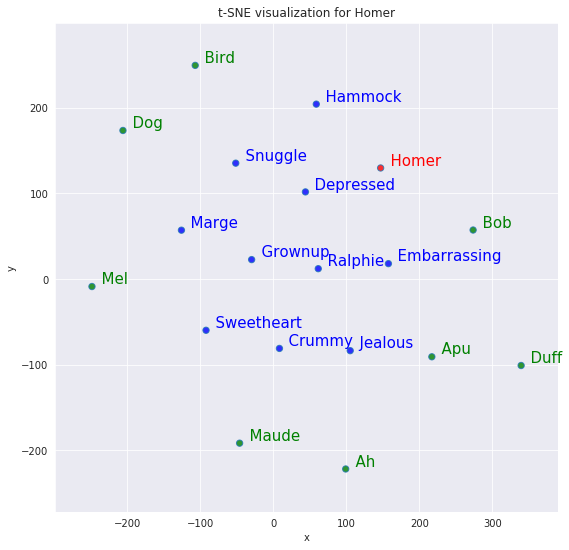

In [39]:
print("\n10 most similar words to Homer vs 8 random ones\n")
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])


10 most similar words to Maggie vs 10 most dissimilar ones



/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


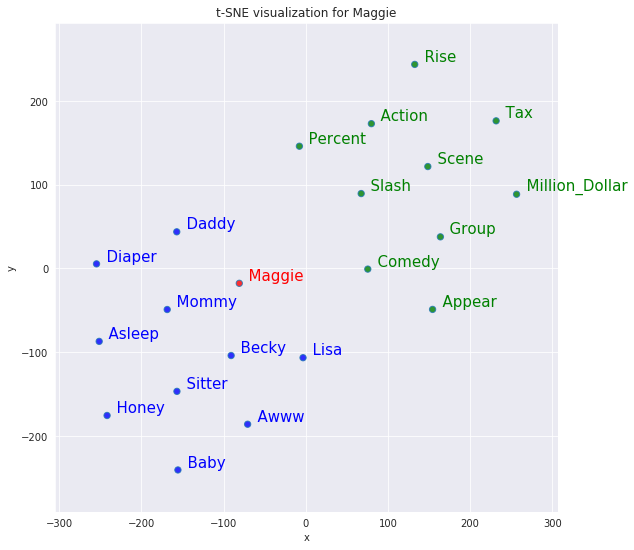

In [40]:
print("\n10 most similar words to Maggie vs 10 most dissimilar ones\n")

tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])